In [21]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from preprocess.extract import generateNNdata

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


In [22]:
def genXy(data, lb, la, scaler):
    n_features = data.shape[1] - 2
    df = data.reset_index(drop=True)

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in tqdm(df.iterrows()):
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        # if dfx.date.nunique() > 1 or dfy.date.nunique() > 1:
        #     continue

        # if dfx.date.unique()[0] != dfy.date.unique()[0]:
        #     continue

        x_vals = scaler.transform(x_vals)
        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time


In [23]:
timeinterval = 30
airport = "EGLL"
lookback, lookahead = 6, 6


In [24]:
dataset = (
    generateNNdata(
        airport,
        timeinterval=timeinterval,
        start=datetime(2018, 1, 1),
        end=datetime(2019, 12, 31),
        catagoricalFlightDuration=False,
        forceRegenerateData=True,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
)


Generating NN data for EGLL with a timeslot length of 30 minutes


In [25]:
# randomly split train, test

# np.random.seed(42)
dates = dataset.date.sort_values().unique()
# np.random.shuffle(dates)

idx_split = int(len(dates) * 0.80)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]

train_data = dataset.query("date in @train_dates").sort_values('timeslot')
test_data = dataset.query("date in @test_dates").sort_values('timeslot')


In [26]:
scaler = StandardScaler()
scaler.fit(dataset.drop(columns=["timeslot", "date"]).values)

StandardScaler()

In [27]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lookback, lookahead, scaler)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lookback, lookahead, scaler)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]


9312it [00:18, 492.74it/s]
2352it [00:03, 668.82it/s]


In [28]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]


In [29]:

# model = Sequential()
# model.add(LSTM(400, input_shape=(n_timesteps, n_features), return_sequences=True))
# model.add(Dropout(0.25))
# model.add(LSTM(200, input_shape=(n_timesteps, n_features), return_sequences=True))
# model.add(Dropout(0.25))
# model.add(TimeDistributed(Dense(100)))
# model.add(Dropout(0.25))
# model.add(TimeDistributed(Dense(2)))

# model.compile(loss="mse", optimizer="adam")

# model.summary()


In [30]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import MeanSquaredError


inputs = layers.Input((lookback, n_features))
lstm1 = layers.LSTM(200, return_sequences=True)
lstm2 = layers.LSTM(200, return_sequences=False)
dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.25)
dense2 = layers.Dense(100)
output = layers.Dense(lookahead * 2)
reshape = layers.Reshape((lookahead, 2))

out = lstm1(inputs)
out = lstm2(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
outputs = output(out)
outputs = reshape(outputs)

model = models.Model(inputs, outputs)

optimizer = optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    weighted_metrics=["acc"],
)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 200)            170400    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 12)                1212

In [31]:
# from keras.utils.vis_utils import plot_model

# plot_model(
#     model,
#     # to_file="model_plot.png",
#     show_shapes=True,
#     show_layer_names=True,
# )


Epoch 1/100
291/291 [==============================] - 5s 10ms/step - loss: 53.8907 - acc: 0.8776 - val_loss: 38.5558 - val_acc: 0.9369
Epoch 2/100
291/291 [==============================] - 2s 8ms/step - loss: 37.5249 - acc: 0.8875 - val_loss: 37.6434 - val_acc: 0.8986
Epoch 3/100
291/291 [==============================] - 2s 8ms/step - loss: 35.2797 - acc: 0.8905 - val_loss: 35.9501 - val_acc: 0.8783
Epoch 4/100
291/291 [==============================] - 2s 8ms/step - loss: 33.4611 - acc: 0.8927 - val_loss: 35.1590 - val_acc: 0.8809
Epoch 5/100
291/291 [==============================] - 2s 8ms/step - loss: 33.0820 - acc: 0.8927 - val_loss: 33.3512 - val_acc: 0.8815
Epoch 6/100
291/291 [==============================] - 2s 8ms/step - loss: 32.0835 - acc: 0.8918 - val_loss: 33.2465 - val_acc: 0.8854
Epoch 7/100
291/291 [==============================] - 2s 8ms/step - loss: 31.5237 - acc: 0.8937 - val_loss: 32.3395 - val_acc: 0.8919
Epoch 8/100
291/291 [==============================] -

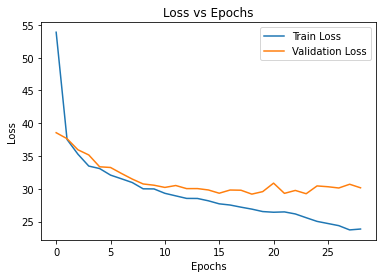

In [32]:

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [33]:
y_test_hat = model.predict(X_test)


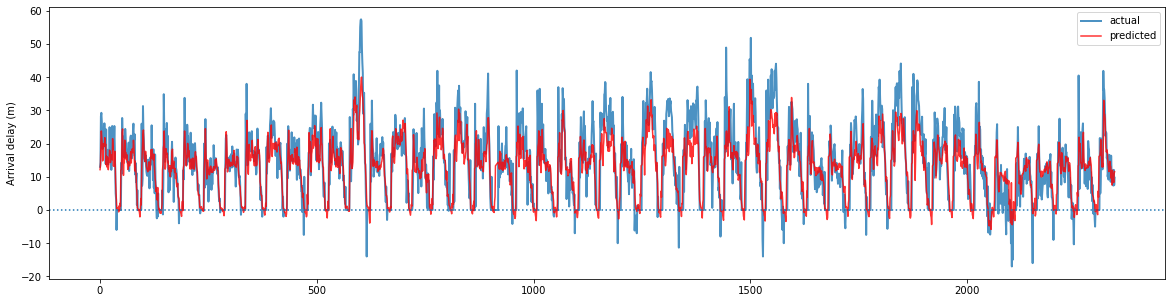

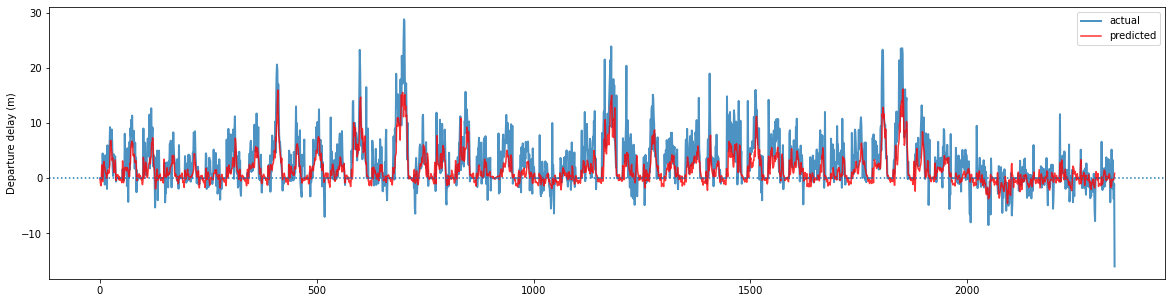

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(y_test_arr[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 0], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Arrival delay (m)")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(y_test_dep[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 1], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Departure delay (m)")
plt.legend()
plt.show()


In [35]:
results = pd.concat(
    [
        pd.DataFrame().assign(time=y_test_time),
        pd.DataFrame(
            y_test[:, :, 0].round().astype(int),
            columns=[f"arr_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test[:, :, 1].round().astype(int),
            columns=[f"dep_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 0].round().astype(int),
            columns=[f"arr_est_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 1].round().astype(int),
            columns=[f"dep_est_{n}m" for n in range(30, 181, 30)],
        ),
    ],
    axis=1,
)

# results


In [36]:
res = dict()
for i in range(1, 7):
    res[i] = {
        "arr_mae": mean_absolute_error(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "arr_rmse": mean_squared_error(
            results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"], squared=False
        ),
        "arr_r2": r2_score(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "dep_mae": mean_absolute_error(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
        "dep_rmse": mean_squared_error(
            results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"], squared=False
        ),
        "dep_r2": r2_score(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
    }

pd.DataFrame.from_dict(res, orient="index")

,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,4.589065,6.306936,0.688695,2.202478,3.294462,0.447801
2,4.593763,6.428857,0.676693,2.184109,3.361655,0.425046
3,4.784280,6.729090,0.646252,2.274669,3.540514,0.368590
4,4.910722,7.015331,0.615537,2.298590,3.545819,0.366697
5,5.239214,7.493611,0.561263,2.243059,3.501205,0.382533
6,5.425459,7.733631,0.532728,2.304571,3.566600,0.359252


In [37]:

results.to_csv("data/airport_delay_lstm_results.csv", index=False)


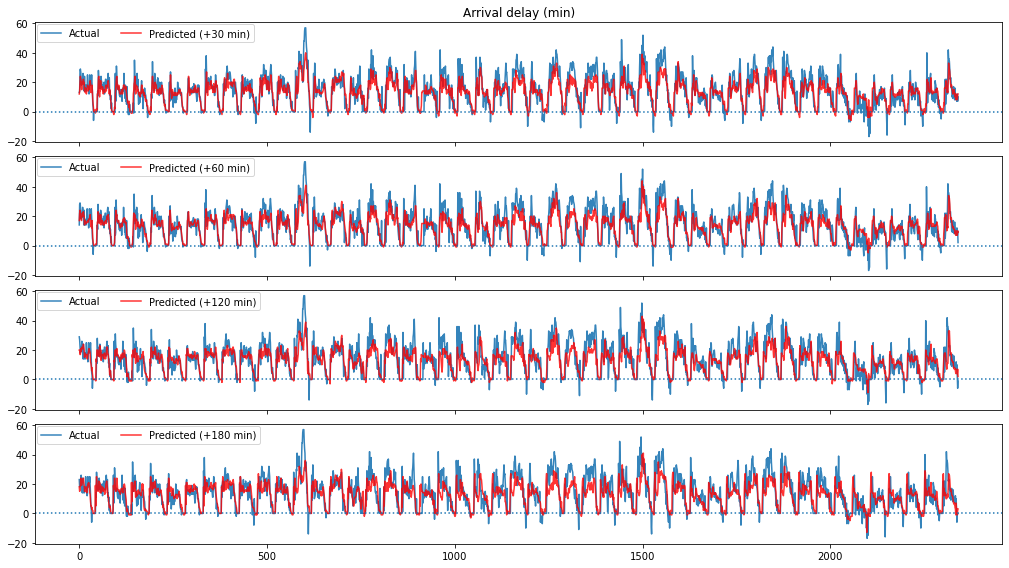

In [38]:
df = results

fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.arr_30m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Arrival delay (min)")


ax = axes[1]
ax.plot(df.arr_60m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.arr_120m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.arr_180m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)


plt.tight_layout()

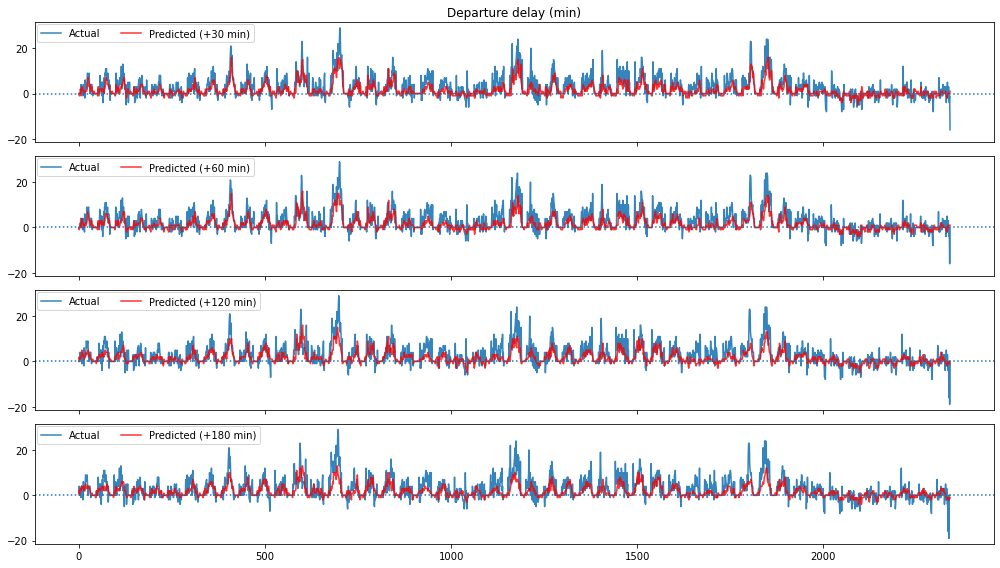

In [39]:
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.dep_30m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Departure delay (min)")


ax = axes[1]
ax.plot(df.dep_60m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.dep_120m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.dep_180m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()
